# Image segmentation using traditonal machine learning

In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Divide the image into Test set and Training set

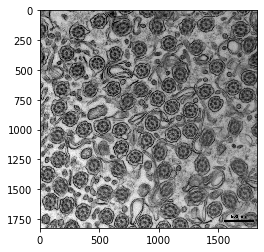

In [13]:
# import the image
img = cv2.imread('images/cilia.jpg')
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_grayscale, cmap='gray')

### Step 2: Create feature bank

In [22]:
# create the DataFrame and fill it with features (see Gabor examples for details)

df = pd.DataFrame()
img_col = img_grayscale.reshape(-1)

# add original pixels to the DataFrame
df['Original_pixels'] = img_col

#GABOR FEATURES
#parameters (allow to generate a large set of features)

ksize = 5 #depends on the feature size you want to enhance | Hardcoded here.
phi = 0 #offset | Hardcoded here

gabor_index = 0
gabor_kernels = []

for theta in range(2):
    theta = theta /4. * np.pi
    for sigma in (3,5):
        for lambd in np.arange(0, np.pi, np.pi /4.):
            for gamma in (0.05, 0.5):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
                gabor_kernels.append(kernel)
                filtered_img = cv2.filter2D(img_grayscale, cv2.CV_8UC3, kernel)
                filtered_img_col = filtered_img.reshape(-1)
                df[f'Gabor_{gabor_index}'] = filtered_img_col
                gabor_index += 1
                
#CANNY FEATURES (edge detector)

canny_min = np.arange(50,200,20)
canny_max = np.arange(50,200,20)

for min in canny_min:
    for max in canny_max:
        img_edges = cv2.Canny(img_grayscale, min, max)
        img_edges_col = img_edges.reshape(-1)
        df[f'Canny_{min}_{max}'] = img_edges_col

#Print the feature stack to see how it looks like                
df.head(20)

,Original_pixels,Gabor_0,Gabor_1,Gabor_2,Gabor_3,Gabor_4,Gabor_5,Gabor_6,Gabor_7,Gabor_8,...,Canny_170_170,Canny_170_190,Canny_190_50,Canny_190_70,Canny_190_90,Canny_190_110,Canny_190_130,Canny_190_150,Canny_190_170,Canny_190_190
0,134,0,0,0,0,0,0,179,175,0,...,0,0,0,0,0,0,0,0,0,0
1,122,0,0,0,0,0,0,160,155,0,...,0,0,0,0,0,0,0,0,0,0
2,133,0,0,0,0,0,0,181,176,0,...,0,0,0,0,0,0,0,0,0,0
3,129,0,0,0,0,0,0,165,160,0,...,0,0,255,0,0,0,0,0,0,0
4,147,0,0,0,0,0,0,142,139,0,...,0,0,0,0,0,0,0,0,0,0
5,146,0,0,0,0,0,0,202,196,0,...,0,0,0,0,0,0,0,0,0,0
6,143,0,0,0,0,0,0,155,151,0,...,0,0,0,0,0,0,0,0,0,0
7,132,0,0,0,0,0,0,178,173,0,...,0,0,0,0,0,0,0,0,0,0
8,140,0,0,0,0,0,0,181,176,0,...,0,0,0,0,0,0,0,0,0,0
9,144,0,0,0,0,0,0,171,167,0,...,0,0,0,0,0,0,0,0,0,0


### Step 3: Create the model and validate it

### Step 4: Find which features are relevant

### Step 5: Save the model as pickle

### Step 6: Use the model for segmentation